<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_ai_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI data analysis

### Setup
- Install & import necessary libraries

In [ ]:
!pip uninstall -y fastai

In [ ]:
# Sometimes the colab fastai version can be wrong, so we reinstall with no cache
# uninstalling, reinstalling, and restarting runtime should fix any major issues. 
!pip install -U --no-cache-dir fastai

In [4]:
import numpy as np
import pandas as pd

from fastai import *
from fastai.tabular import *
from fastai.vision import *
from fastai.vision.all import *
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

#print(fastai.__version__)

### Data Pre-processing

##### TODO
- preprocess images 
- Slice low-res images 
- upscale low-res ones to be the same size as the required input 
- resize high-res test outputs to required output
- Map low-res input images to high-res output images using GeoTIFF metadata 
- utilise image transformations to expand dataset as much as possible 
   - Rotations 
   - Translations 
   - use the same data at different times of year/day 
   - Different countries 

In [32]:
drive_path = "/content/drive/MyDrive/"

CO_band = 'CO_column_number_density'
HCHO_band = 'tropospheric_HCHO_column_number_density'
NO2_band = 'tropospheric_NO2_column_number_density'
O3_band = 'O3_column_number_density'
SO2_band = 'SO2_column_number_density'
CH4_band = 'CH4_column_volume_mixing_ratio_dry_air'

In [65]:
# Import data from google drive 
path = drive_path + "img_export"
imgs = get_image_files(path + "/png")

In [66]:
len(imgs)
#print(imgs)

1055

## Parse CSVs into pandas dataframe 

In [36]:
ghg_df = pd.read_csv(f"{path}/{SO2_band}.csv")

## Implement label function 

In [68]:
# Define a label function for image data by getting centroid long and lat from image filename, then accessing the 
# corresponding GHG values from the pandas dataframe defined above. 
def label_func(file):
  # string formatting always feels like some kind of evil act. 
  print(file)
  coords = list(map(float, file.split("/")[-1][0:-4].split("_")))
  df.longitude == coords[0] and df.latitude == coords[1]
  return True 

In [64]:
label_func(f"{path}/png/0.39975030143318707_51.136597548503765.png")

/content/drive/MyDrive/img_export/png/0.39975030143318707_51.136597548503765.png


True

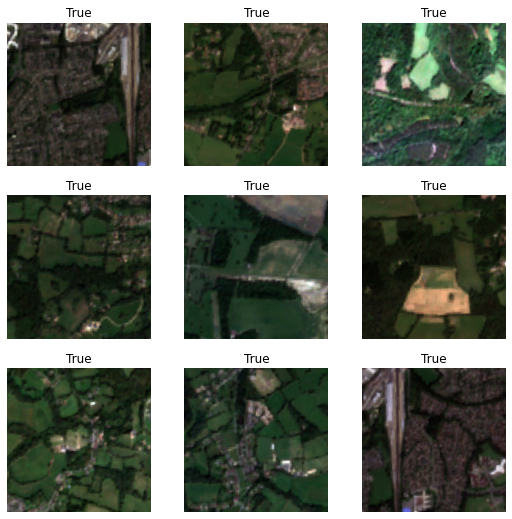

In [14]:
# Define ImageDataLoader
# TODO look into other item_tfms options - what other transforms can be done?
# - 90-degree rotations
# - Slicing and dicing these together (would that work?..)
# TODO batch size is set to 1 because we're currently under the threshold of the standard bs (64). Update this once the data source is sorted. 
imgLoader = ImageDataLoaders.from_name_func(path, imgs, label_func, item_tfms=Resize(224))
imgLoader.show_batch()

### Training

- Train image-based predictor to guess greenhouse gas concentrations based on 1km square of land. 
  - Transfer an ImageNet predictor to work top-down
  - Start by predicting one ghg and expand from there
- Use image predictor to extract a basic feature set by slicing the network at different points. The idea is to limit the amount of data going into the tabular recommender, while transferring as much useful data as possible. We want to implicitly extract GHG-emitting features of each image without losing any detail, as a form of convolutional preprocessing. 
- pipe this feature extractor into a tabular recommender along with other feature data that may either improve tabular predictions by influencing GHG concentrations, or hint at subtle relationships between prospectively disparate factors:
  - Land prices
  - Prevailing wind direction 
  - Land use 
  - Population density
  - Economic output
  - Land height
  - Biodiversity
  - Atmospheric water vapour. 
  - **NB This is not something to get excessively distracted by - finish the basics before looking for further data** 

In [ ]:
imgLearner = cnn_learner(imgLoader, resnet34, metrics=error_rate)
imgLearner.fine_tune(1)

### Analysis